# 4. Low-rank AAP Analysis

This notebook analyzes the Low-rank Associated Attribute Prediction module.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from models.lowrank_aap import LowRankAAP, FullRankAAP, compare_aap_modules
from models.s3rec import S3RecModel, S3RecLowRankModel

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

## Parameter Reduction Analysis

In [2]:
hidden_size = 64
ranks = [4, 8, 16, 32, 48]

full_rank = FullRankAAP(hidden_size)
full_params = full_rank.get_parameter_count()['fullrank_params']

print(f"Full-rank AAP: {full_params:,} parameters")
print("\nLow-rank comparison:")
print("-" * 40)

reductions = []
for rank in ranks:
    lr = LowRankAAP(hidden_size, rank)
    stats = lr.get_parameter_count()
    reductions.append(stats)
    print(f"r={rank:2d}: {stats['lowrank_params']:,} params ({stats['reduction_percent']} reduction)")

Full-rank AAP: 4,160 parameters

Low-rank comparison:
----------------------------------------
r= 4: 512 params (87.5% reduction)
r= 8: 1,024 params (75.0% reduction)
r=16: 2,048 params (50.0% reduction)
r=32: 4,096 params (0.0% reduction)
r=48: 6,144 params (-50.0% reduction)


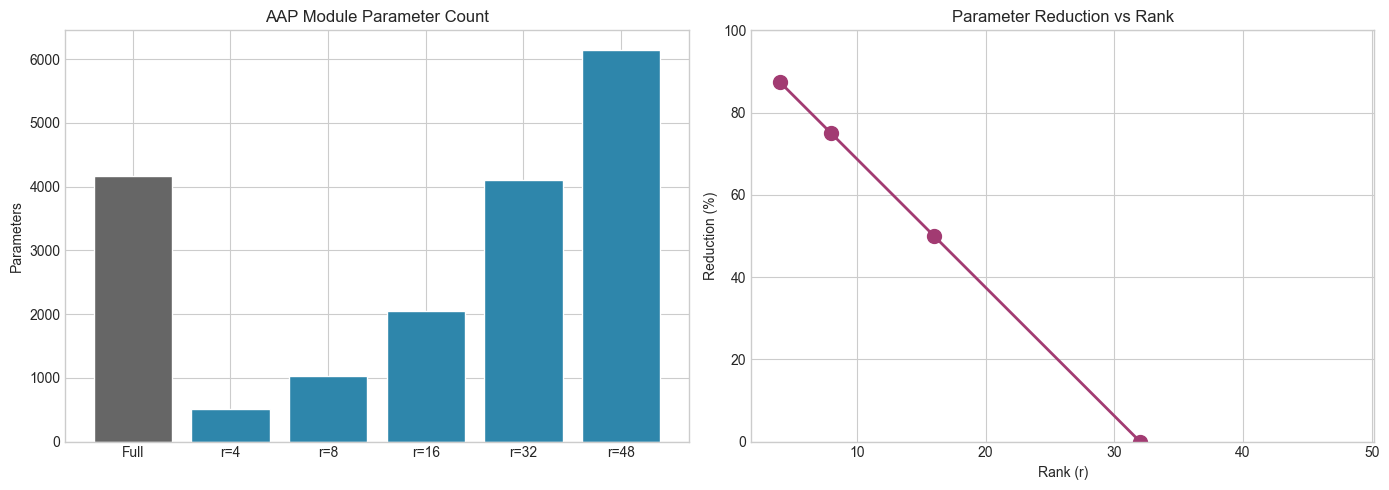

In [3]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameter count
ax1 = axes[0]
x = ['Full'] + [f'r={r}' for r in ranks]
y = [full_params] + [r['lowrank_params'] for r in reductions]
colors = ['#666666'] + [COLORS[0]] * len(ranks)

ax1.bar(x, y, color=colors, edgecolor='white')
ax1.set_ylabel('Parameters')
ax1.set_title('AAP Module Parameter Count')

# Reduction percentage
ax2 = axes[1]
y_red = [r['reduction_ratio'] * 100 for r in reductions]
ax2.plot(ranks, y_red, 'o-', color=COLORS[1], linewidth=2, markersize=10)
ax2.set_xlabel('Rank (r)')
ax2.set_ylabel('Reduction (%)')
ax2.set_title('Parameter Reduction vs Rank')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../results/figures/lowrank_analysis.png', dpi=150)
plt.show()

## Full Model Comparison

In [4]:
num_items = 12102
num_attrs = 1221

baseline = S3RecModel(num_items, num_attrs, hidden_size=64)
baseline_params = baseline.get_parameter_count()['total']

print(f"Baseline S3Rec: {baseline_params:,} parameters")
print("\nLow-rank S3Rec:")

for rank in [8, 16, 32]:
    model = S3RecLowRankModel(num_items, num_attrs, hidden_size=64, rank=rank)
    red = model.get_parameter_reduction()
    print(f"  r={rank}: {red['lowrank_total']:,} ({red['reduction_percent']})")

Baseline S3Rec: 972,544 parameters

Low-rank S3Rec:
  r=8: 966,272 (0.64%)
  r=16: 968,320 (0.43%)
  r=32: 972,416 (0.01%)
